# scGPT

scGPT, based on a generative pretrained transformer across a repository of over 33 million cells. Our findings illustrate that scGPT effectively distills critical biological insights concerning genes and cells. Through further adaptation of transfer learning, scGPT can be optimized to achieve superior performance across diverse downstream applications. 

Here, you can use `omicverse.llm.SCLLMManager(model_type="scgpt")` to call this model directly.

Cite: Cui, H., Wang, C., Maan, H., Pang, K., Luo, F., Duan, N., & Wang, B. (2024). scGPT: toward building a foundation model for single-cell multi-omics using generative AI. Nature methods, 21(8), 1470-1480.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Load example datasets

For this tutorial, we use three batches from the NeurIPS 2021 single-cell competition dataset, which provides an excellent test case for batch integration and cell type annotation.

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [2]:
adata1=ov.read('data/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [3]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## scGPT

we need to download the model checkpoint from here: https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y/

In [5]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None,target_sum=1e4)
adata

Begin robust gene identification
After filtration, 13953/13953 genes are kept.     Among 13953 genes, 13953 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'HBB', 'MALAT1', 'IGHA1', 'IGHM', 'HBA2', 'IGLC1', 'IGLC2', 'IGLC3']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 3.081930160522461 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Download pre-trained model and dictionaries

The scGPT model checkpoint contains:
- **args.json**: Model architecture configuration
- **best_model.pt**: Pre-trained model weights (~205MB)
- **vocab.json**: Gene vocabulary mapping (60,697 genes)

Download from: https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y/

In [5]:
#!/usr/bin/env python3
import os
import gdown

folder_url = 'https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y'

output_dir = 'llm_model/models/scgpt'

os.makedirs(output_dir, exist_ok=True)

gdown.download_folder(
    url=folder_url,
    output=output_dir,
    quiet=False,        # 显示下载进度
    use_cookies=False   # 根据需要切换
)

Retrieving folder contents


Processing file 1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1 args.json
Processing file 14AebJfGOUF047Eg40hk57HCtrb0fyDTm best_model.pt
Processing file 1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC vocab.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1
To: /scratch/users/steorra/analysis/25_scllm/llm_model/models/scgpt/args.json
100%|██████████| 1.30k/1.30k [00:00<00:00, 11.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm
From (redirected): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm&confirm=t&uuid=bce7552f-cae8-4820-9be5-29a0beb12b2a
To: /scratch/users/steorra/analysis/25_scllm/llm_model/models/scgpt/best_model.pt
100%|██████████| 205M/205M [00:04<00:00, 43.6MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC
To: /scratch/users/steorra/analysis/25_scllm/llm_model/models/scgpt/vocab.json
100%|██████████| 1.32M/1.32M [00:00<00:00, 15.2MB/s]
Download completed


['llm_model/models/scgpt/args.json',
 'llm_model/models/scgpt/best_model.pt',
 'llm_model/models/scgpt/vocab.json']

## Initialize scGPT model

First, we need to download the pre-trained scGPT model checkpoint. The model was trained on a large corpus of single-cell data and can be directly applied to new datasets for various downstream tasks.

In [4]:
manager = ov.llm.SCLLMManager(
    model_type="scgpt",
    model_path="llm_model/models/scgpt",
)

[Loaded] Loaded vocabulary: 60,697 genes
[Loaded] Loaded model config from args.json
[ℹ️] Key Parameters Model Information:
    embsize: 512
    nheads: 8
    d_hid: 512
    nlayers: 12
    n_layers_cls: 3
[Preprocessing] Analyzing model checkpoint for n_cls inference...
[Warning] No classifier layers found in checkpoint
[ℹ️] Using default n_cls=50
[Warning] Loading compatible weights only
[Loaded] Compatible weights loaded: 135/163
[Warning] Some weights incompatible (28)
[ℹ️] Model classes: 50
[Loaded] Model ready on cuda


## Zero-shot embedding generation

Zero-shot embedding refers to generating cell representations using the pre-trained model without any fine-tuning on the specific dataset. This leverages the knowledge learned from millions of cells during pre-training to create meaningful representations of new cells.

[Cells] Data Summary:
    Cells: 27,423
    Genes: 3,000
    Batches: 3
      s3d7: 11,230 cells
      s2d1: 10,258 cells
      s1d3: 5,935 cells
[Embedding] Starting get_embeddings...
    cells: 27,423
    genes: 3,000
[Preprocessing] Filtering genes by vocabulary
[ℹ️] Matched 2738/3000 genes
[Loaded] Retained 2738 genes
[Loaded] Preprocessor initialized
    n_bins: 51, normalize: 10000.0
[ℹ️] Data inspection - Mean: 1085.7, Range: [0.000, 11.615]
    [ℹ️] Auto-detected: raw counts
    [Warning] User override: skipping normalization
    [Preprocessing] Adjusting preprocessor settings
[Preprocessing] Applying preprocessing pipeline
Binning data ...
    [Loaded] Preprocessor settings restored
[Loaded] Preprocessing completed
[Loaded] Binned data: (27423, 2738), 51 unique values
    Data shape: (27423, 2738)
    Data range: [0.000, 50.000]
    Gene IDs: 2738 genes mapped
    [Preprocessing] Tokenizing data...
    Tokenized: 27423 cells x 1200 tokens
    Created dataloader: 857 batches (b

[scGPT] Prediction batches:   0%|          | 2/857 [00:00<01:08, 12.50it/s]

        Batch shape: torch.Size([32, 1200])
        Padding tokens: 17283
        Embeddings: 512 dimensions


    Predictions: 2 classes for 27,423 cells
    Extracted embeddings: (27423, 512)
[Complete] get_embeddings completed successfully!
[Complete] Results summary:
    embedding_shape: (27423, 512)
    embedding_dim: 512
embedding: (27423, 512)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)


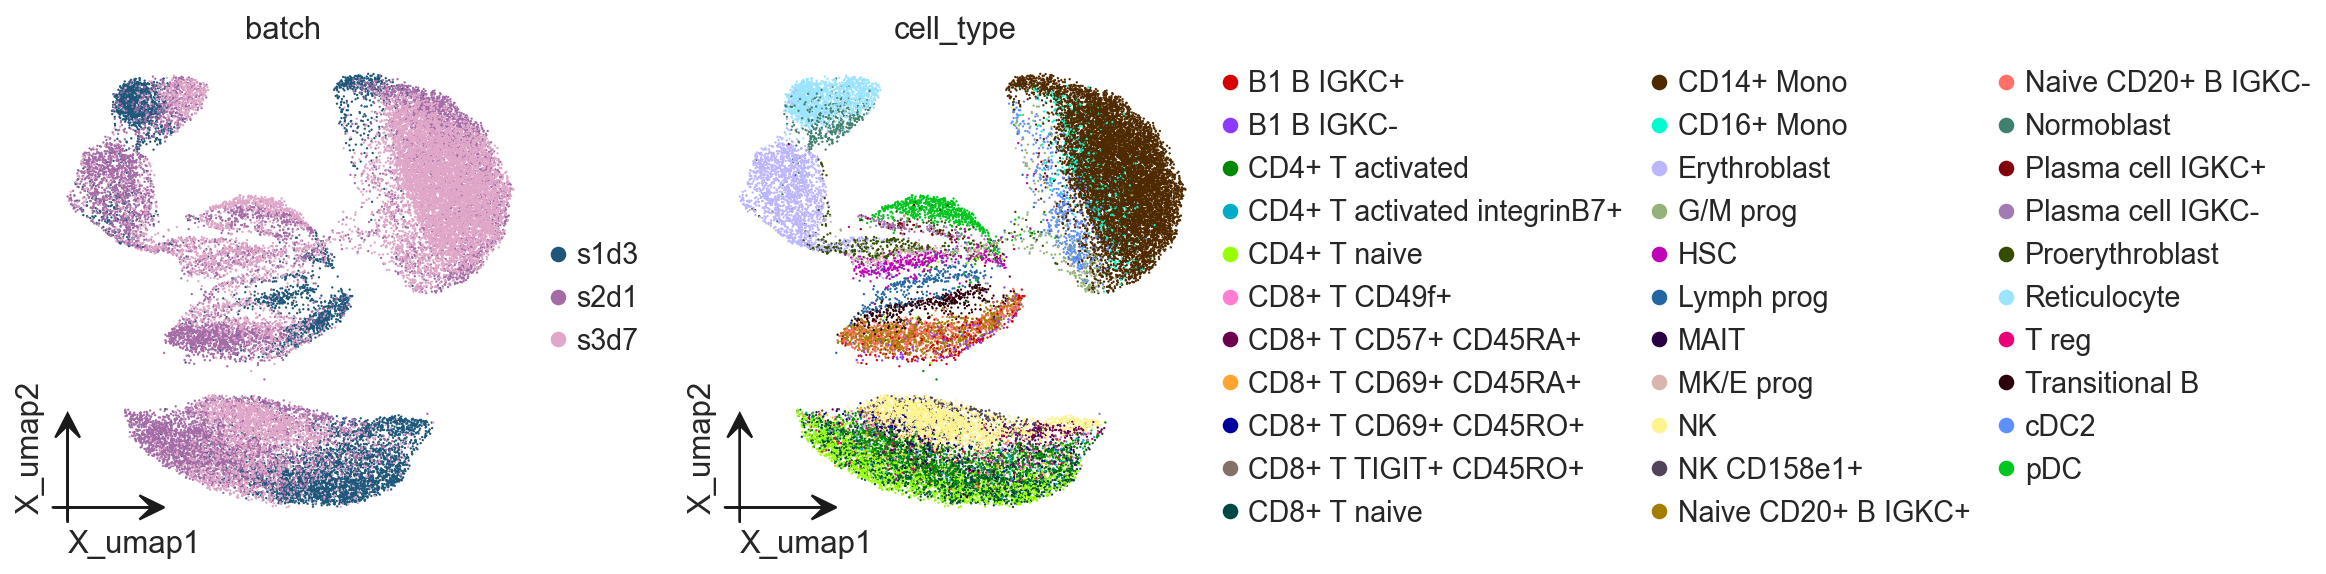

In [7]:
embeddings = manager.get_embeddings(adata,skip_normalization=True,)
print(f"embedding: {embeddings.shape}")

adata.obsm['X_scgpt'] = embeddings

sc.pp.neighbors(adata, use_rep='X_scgpt')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

## Fine-tuning on reference data

Fine-tuning adapts the pre-trained model to your specific dataset, improving performance on:
- Cell type classification accuracy
- Batch effect correction
- Dataset-specific features

We'll use one batch (s1d3) as a reference dataset with known cell type labels to fine-tune the model. This creates a specialized version that better understands the specific cell types and expression patterns in our data.

In [8]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [9]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [10]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=5,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
    mask_ratio=0.0,      # 
    data_is_raw=False,
    log1p=False,
    skip_normalization=True,
)



[SCGPT] FINE-TUNING FOR ANNOTATION TASK
[ℹ️] Training Configuration Model Information:
    epochs: 5
    batch_size: 32
    learning_rate: 0.0001
    mask_ratio: 0.0
[ℹ️] Cell types: 30 classes
[Preprocessing] Preprocessing data...
[Preprocessing] Filtering genes by vocabulary
[ℹ️] Matched 2738/3000 genes
[Loaded] Retained 2738 genes
[ℹ️] Data inspection - Mean: 1013.7, Range: [0.000, 11.387]
    [ℹ️] Auto-detected: raw counts
    [Warning] User override: skipping normalization
    [Preprocessing] Adjusting preprocessor settings
[Preprocessing] Applying preprocessing pipeline
Binning data ...
    [Loaded] Preprocessor settings restored
[Loaded] Preprocessing completed
[Loaded] Binned data: (5935, 2738), 51 unique values
[Preprocessing] Updating classifier: 50 → 30 classes
[Loaded] Classifier updated
[Training] Starting training...


[Loaded] Loaded best model (accuracy: 0.8239)


### Batch integration with fine-tuned model

After fine-tuning, we can use the model to generate improved embeddings with batch correction. The integration process:
1. Generates embeddings using the fine-tuned model
2. Applies MNN (Mutual Nearest Neighbors) correction to align batches
3. Preserves biological variation while removing technical effects

In [11]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
    log1p=False,
    data_is_raw=False,
    skip_normalization=True,
)
adata.obsm['X_scgpt_fine'] = zero_shot_results['embeddings']

[ℹ️] Using pre-trained model with post-hoc correction
    [Embedding] Extracting pre-trained embeddings
[Cells] Data Summary:
    Cells: 27,423
    Genes: 3,000
    Batches: 3
      s3d7: 11,230 cells
      s2d1: 10,258 cells
      s1d3: 5,935 cells
[Embedding] Starting get_embeddings...
    cells: 27,423
    genes: 3,000
[Preprocessing] Filtering genes by vocabulary
[ℹ️] Matched 2738/3000 genes
[Loaded] Retained 2738 genes
[ℹ️] Data inspection - Mean: 1085.7, Range: [0.000, 11.615]
    [ℹ️] Auto-detected: raw counts
    [Warning] User override: skipping normalization
    [Preprocessing] Adjusting preprocessor settings
[Preprocessing] Applying preprocessing pipeline
Binning data ...
    [Loaded] Preprocessor settings restored
[Loaded] Preprocessing completed
[Loaded] Binned data: (27423, 2738), 51 unique values
    Data shape: (27423, 2738)
    Data range: [0.000, 50.000]
    Gene IDs: 2738 genes mapped
    [Preprocessing] Tokenizing data...
    Tokenized: 27423 cells x 1200 tokens
   

[scGPT] Prediction batches:   0%|          | 4/857 [00:00<00:22, 38.54it/s]

        Batch shape: torch.Size([32, 1200])
        Padding tokens: 17283
        Embeddings: 512 dimensions


    Predictions: 23 classes for 27,423 cells
    Extracted embeddings: (27423, 512)
[Complete] get_embeddings completed successfully!
[Complete] Results summary:
    embedding_shape: (27423, 512)
    embedding_dim: 512
    [ℹ️] Found 3 batches
    [Preprocessing] Applying MNN-inspired correction
        [Loaded] MNN correction applied
[Loaded] Integration completed using mnn correction


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


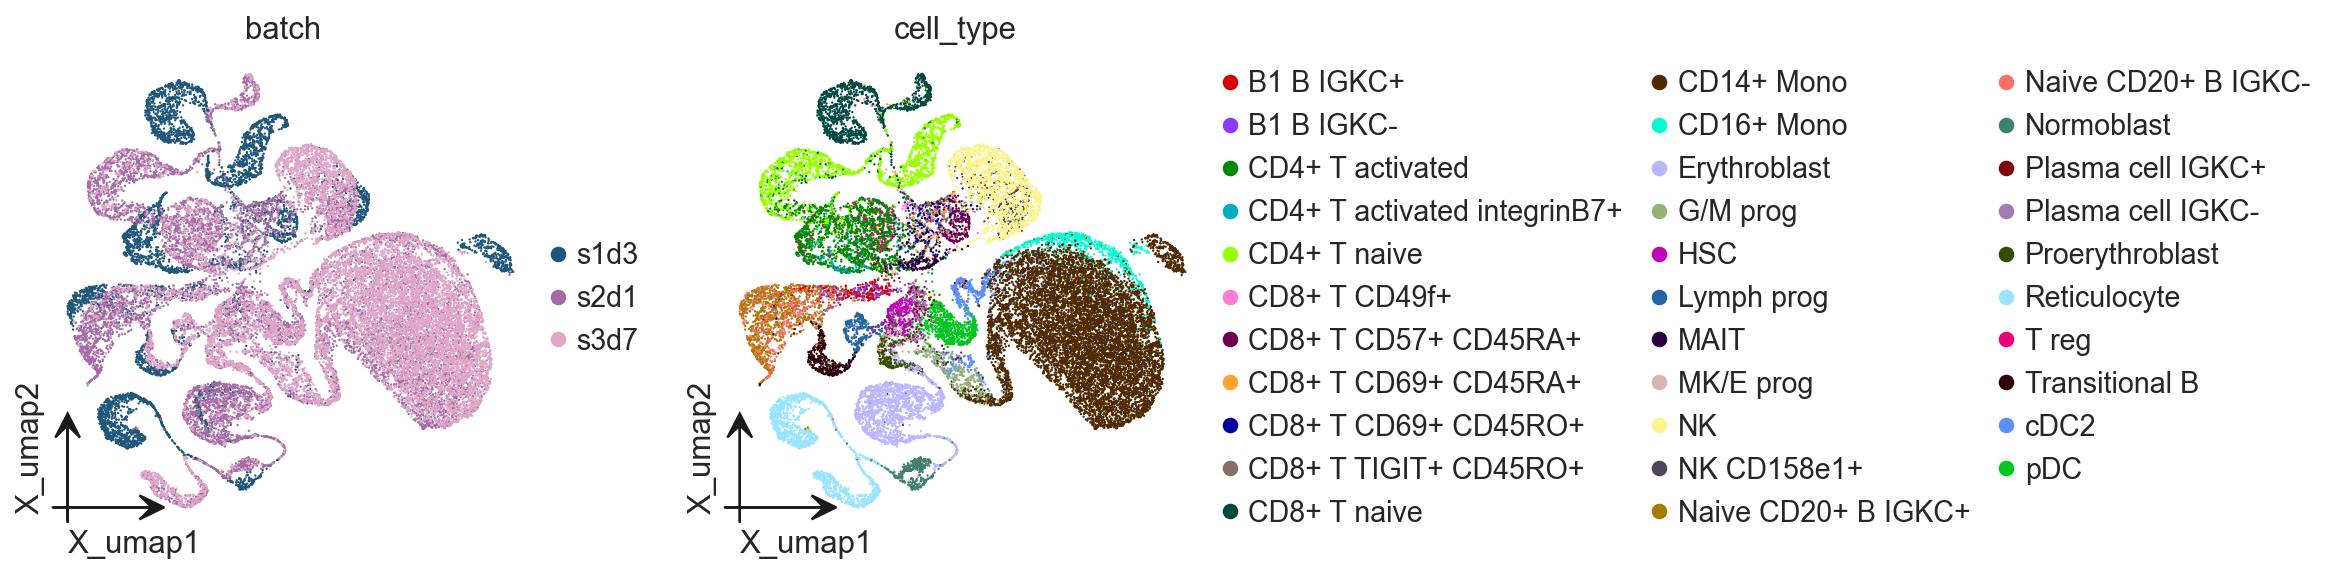

In [12]:
sc.pp.neighbors(adata, use_rep='X_scgpt_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### Cell type annotation

The fine-tuned model can now be used to predict cell types for all cells in the dataset, including those from batches not used in training. This demonstrates the model's ability to generalize to new data.

In [13]:
prediction_results = manager.model.predict_celltypes(
    adata,
    skip_normalization=True,
)

adata.obs['predicted_celltype'] = prediction_results['predicted_celltypes']
adata.obs['predicted_celltype_id'] = prediction_results['predictions']

[Predicting] Starting predict_celltypes...
    cells: 27,423
    genes: 3,000
    [Preprocessing] Preprocessing query data...
[Preprocessing] Filtering genes by vocabulary
[ℹ️] Matched 2738/3000 genes
[Loaded] Retained 2738 genes
[ℹ️] Data inspection - Mean: 1085.7, Range: [0.000, 11.615]
    [ℹ️] Auto-detected: raw counts
    [Warning] User override: skipping normalization
    [Preprocessing] Adjusting preprocessor settings
[Preprocessing] Applying preprocessing pipeline
Binning data ...
    [Loaded] Preprocessor settings restored
[Loaded] Preprocessing completed
[Loaded] Binned data: (27423, 2738), 51 unique values
    Data shape: (27423, 2738)
    Data range: [0.000, 50.000]
    Gene IDs: 2738 genes mapped
    [Preprocessing] Tokenizing data...
    Tokenized: 27423 cells x 1200 tokens
    Created dataloader: 857 batches (batch_size=32)
    [Predicting] Running model inference...


[scGPT] Prediction batches:   0%|          | 4/857 [00:00<00:22, 38.53it/s]

        Batch shape: torch.Size([32, 1200])
        Padding tokens: 17283
        Embeddings: 512 dimensions


    Predictions: 23 classes for 27,423 cells
    Extracted embeddings: (27423, 512)
[Complete] predict_celltypes completed successfully!
[Complete] Results summary:
    total_cells: 27,423
    unique_types: 23
    most_common: CD14+ Mono
    Cell type distribution:
        CD14+ Mono: 10,194 cells (37.2%)
        CD4+ T activated: 2,183 cells (8.0%)
        NK: 2,087 cells (7.6%)
        CD4+ T naive: 1,930 cells (7.0%)
        Erythroblast: 1,539 cells (5.6%)
        Reticulocyte: 1,506 cells (5.5%)
        HSC: 1,417 cells (5.2%)
        Naive CD20+ B IGKC+: 1,358 cells (5.0%)
        CD8+ T naive: 1,263 cells (4.6%)
        Lymph prog: 664 cells (2.4%)
        cDC2: 606 cells (2.2%)
        CD8+ T CD57+ CD45RA+: 552 cells (2.0%)
        Normoblast: 437 cells (1.6%)
        MAIT: 398 cells (1.5%)
        G/M prog: 339 cells (1.2%)
        Transitional B: 327 cells (1.2%)
        Naive CD20+ B IGKC-: 275 cells (1.0%)
        B1 B IGKC-: 153 cells (0.6%)
        Proerythroblast: 144 ce

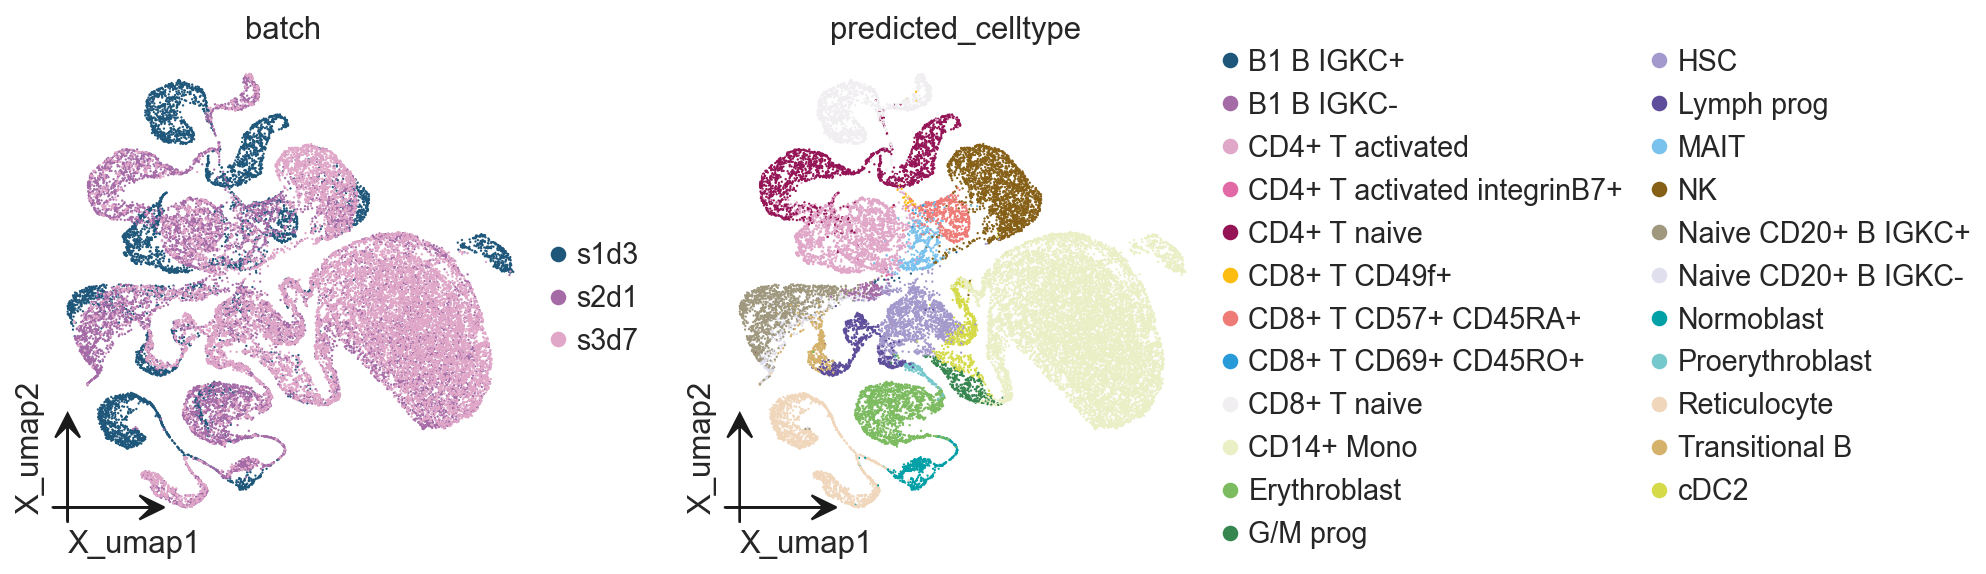

In [14]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)